In [1]:
import torch
import matplotlib.pyplot as plt
from common import *
import time
import copy
import gym

import xarray as xr
import numpy as np

import os
import matplotlib

def do_rollout_pert(env, policy, initial_pos, num_steps=10):
    torch.autograd.set_grad_enabled(False)
    act_list = []
    obs_list = []
    rew_list = []

    dtype = torch.float32
    obs = my_reset(env, initial_pos)
    done = False

    for cur_step in range(num_steps):
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        obs_list.append(obs.clone())

        act = policy(obs)
        obs, rew, done, _ = env.step(act.numpy())
        
        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)


    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew



def do_contact_rollout(env, policy, ep_length, render=False):
    torch.autograd.set_grad_enabled(False)

    act_list = []
    obs_list = []
    rew_list = []
    con_list = []

    dtype = torch.float32
    obs = env.reset()
    cur_step = 0

    while cur_step < ep_length:
        obs = torch.as_tensor(obs, dtype=dtype)
        obs_list.append(obs.clone())
        con_list.append(env.unwrapped.sim.data.ncon)

        act = policy(obs)
        obs, rew, done, _ = env.step(act.numpy())

        if render:
            env.render()
            time.sleep(.01)
        
        # if ep_length > 500 and rew < 0:
        #     env.render()

        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)

        cur_step += 1

    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)
    
    ep_con = torch.tensor(con_list, dtype=dtype)
    ep_con = ep_con.reshape(-1, 1)


    # if ep_rew.sum() < 0:
    #     while True:
    #         obs = torch.as_tensor(obs, dtype=dtype)
    #         obs_list.append(obs.clone())
            
    #         act = policy(obs)
    #         obs, rew, done, _ = env.step(act.numpy())

    #         env.step(act)
    #         env.render()
    #         time.sleep(.01)
                

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, ep_con


def do_rollout_until_no_contact(env, policy, initial_pos, num_steps=10):

    
    torch.autograd.set_grad_enabled(False)
    act_list = []
    obs_list = []
    rew_list = []
    con_list = []


    dtype = torch.float32
    obs = my_reset(env, initial_pos)
    done = False

    for cur_step in range(num_steps):
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        obs_list.append(obs.clone())        

        act = policy(obs)
        obs, rew, done, _ = env.step(act.numpy())
        
        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)
        
        con_list.append(env.unwrapped.sim.data.ncon)
 
        if not con_list[-1]:
            break


    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)
        
    ep_con = torch.tensor(con_list, dtype=dtype)
    ep_con = ep_con.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, ep_con

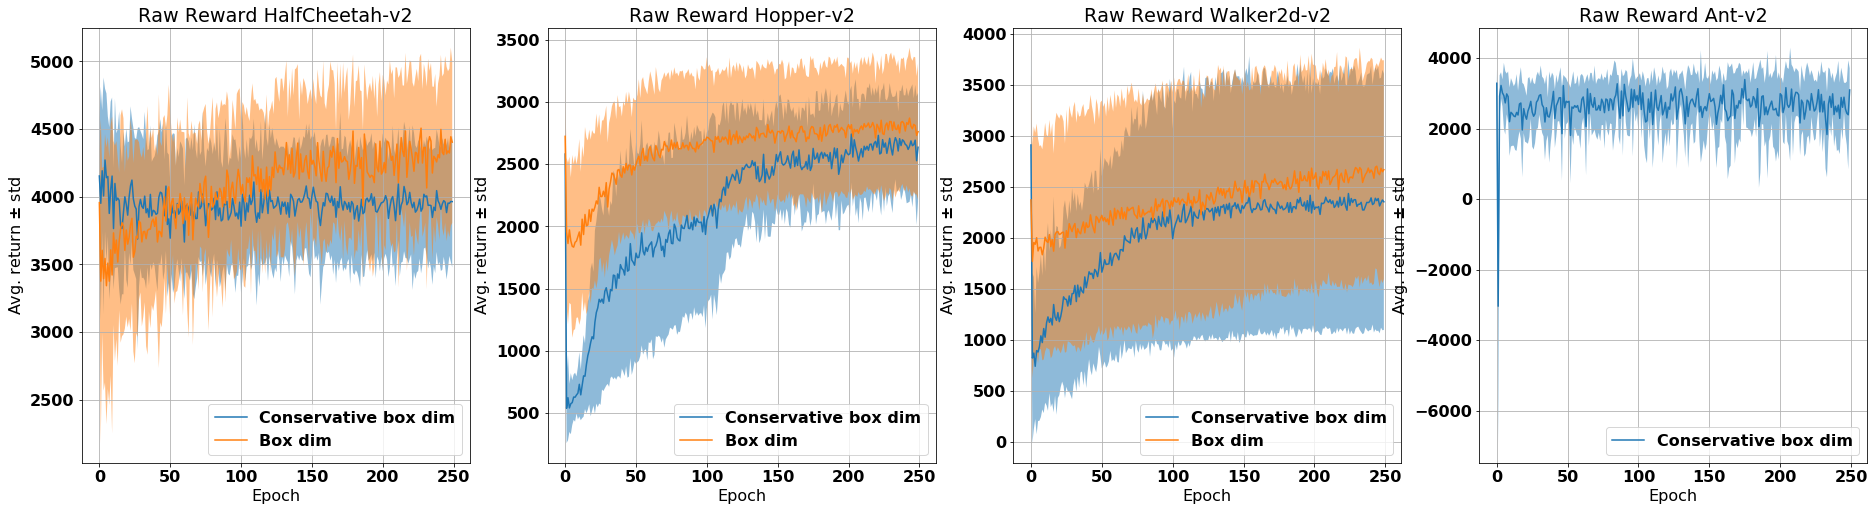

In [2]:
env_names = ["HalfCheetah-v2", "Hopper-v2", "Walker2d-v2", "Ant-v2"]
init_names = ["identity", "madodiv", "identity", "identity"]

font = {'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

fig, ax = plt.subplots(1, len(env_names), figsize=(32,8))

i = 0 
for env_name, init_name in zip(env_names, init_names):
    init_data = torch.load(f"./data17/{env_name}.xr")
    init_policy_dict = init_data.policy_dict
    
    data = torch.load(f"./data_mcshdim4/{env_name}.xr")
    policy_dict = data.policy_dict
    rews = data.rews#/data.post_rews
    exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
    num_seeds = len(policy_dict[exp_names[0]])

    means = rews.mean(dim="trial")
    stds = rews.std(dim="trial")

    #plt.subplots(1,1, figsize=(10,7))
    ax[i].plot(means.T)
    ax[i].legend(['Conservative box dim', 'Box dim'], loc='lower right')
    ci = stds

    for mean, c in zip(means, ci):
        ax[i].fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
        
    ax[i].set_title(f"Raw Reward {env_name}")
    ax[i].set_ylabel(r"Avg. return $\pm$ std")
    ax[i].set_xlabel(r"Epoch")
    ax[i].grid()
    i+=1
    
#     for exp_name in exp_names:  
#         plt.plot(rews.loc[exp_name].T[:,0:10])
#         plt.legend([i for i in range(10)])
#         plt.title(exp_name)
#         plt.figure()
    

In [3]:
#===============================
# env_name = "Walker2d-v2"
# post_names = ['identity', 'mdim_div']

# def my_reset(env, point):
#     env.reset()
#     qpos = np.concatenate((np.array([0.0]), point[:8]))
#     qvel = point[8:]
#     env.unwrapped.set_state(qpos, qvel)
#     return env.unwrapped._get_obs()

# seeds = [0,1,3,4,5,6,8,9]
# rollout_length = 2000
# lookback_length = 50
#===============================
# env_name = "HalfCheetah-v2"
# post_names = ['identity', 'mdim_div']

# def my_reset(env, point):
#     env.reset()
#     qpos = np.concatenate((np.array([0.0]), point[:8]))
#     qvel = point[8:]
#     env.unwrapped.set_state(qpos, qvel)
#     return env.unwrapped._get_obs()

# seeds = [0,1,2,3,4,5,6,7,8,9]
# rollout_length = 100
# lookback_length = 5
#===============================
env_name = "Hopper-v2"
post_names = ['madodiv', 'mdim_div']

def my_reset(env, point):
    env.reset()
    qpos = np.concatenate((np.array([0.0]), point[:5]))
    qvel = point[5:]
    env.unwrapped.set_state(qpos, qvel)
    return env.unwrapped._get_obs()

seeds = [0,1,2,3,4,5,6,7,8,9]
rollout_length = 200
lookback_length = 50
# ===============================



env = gym.make(env_name)
n_states = env.observation_space.shape[0]
data = torch.load(f"./data_mcshdim4/{env_name}.xr")
policy_dict = data.policy_dict

init_data = torch.load(f"./data17/{env_name}.xr")
init_pol_dict = init_data.policy_dict
policy_dict['identity'] = init_pol_dict['identity']
policy_dict['madodiv'] = init_pol_dict['madodiv']



exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
num_seeds = len(policy_dict[exp_names[0]])
mesh_sizes_dict = {}

running build_ext


In [6]:
num_seeds = len(seeds)
num_runs = 10
     
eigs = xr.DataArray(np.zeros((2, num_seeds, num_runs, n_states), dtype=np.complex),
                dims = ("post", "seed", "run", "eig_vals"),
                coords = {"post": post_names})

eigs_bc = xr.DataArray(np.zeros((2, num_seeds, num_runs, n_states), dtype=np.complex),
                dims = ("post", "seed", "run", "eig_vals"),
                coords = {"post": post_names})


eigs_in = xr.DataArray(np.zeros((2, num_seeds, num_runs, n_states), dtype=np.complex),
                dims = ("post", "seed", "run", "eig_vals"),
                coords = {"post": post_names})

failed = False
for post in post_names:
    for i_seed, seed in enumerate(seeds):
        for run in range(num_runs):
            #post = 'identity'; seed = 1

            policy = policy_dict[post][seed]

            nom_obs, nom_acts, nom_rews, nom_con = do_contact_rollout(env,policy,1000)

            i_nom_obs = 500
            while not (not nom_con[i_nom_obs] and nom_con[i_nom_obs+1]):
                i_nom_obs+=1
                if i_nom_obs >= 998:
                    failed = True
                    break
                    
            if failed:
                print(f"post {post}, seed {seed}, run {run} failed!")
                eigs.loc[post][i_seed][run] = float('nan')
                eigs_bc.loc[post][i_seed][run] = float('nan')
                failed = False
                continue
           
            nominal_state = nom_obs[i_nom_obs]

            #obs, acts, rews = do_rollout_pert(env, policy, nominal_state, num_steps=11)
            #cmp_point = obs[-1]

            delta = .05

            initial_conditions = []
            for i,s in enumerate(nominal_state):
                nominal_state_p = np.copy(nominal_state)
                nominal_state_m = np.copy(nominal_state)
                nominal_state_p[i] += delta
                nominal_state_m[i] -= delta

                initial_conditions.append((nominal_state_p, nominal_state_m))


            eig_mat = np.zeros((n_states,n_states))
            eig_mat_bc = np.zeros((n_states,n_states))
            eig_mat_in = np.zeros((n_states,n_states))


            for i, initial_condition in enumerate(initial_conditions):
                init_state_p , init_state_m = initial_condition
                rollout_obs_p, rollout_acts_p, rollout_rews_p, rollout_con_p  = do_rollout_until_no_contact(env,policy, init_state_p, num_steps=rollout_length)
                rollout_obs_m, rollout_acts_m, rollout_rews_m, rollout_con_m  = do_rollout_until_no_contact(env,policy, init_state_m, num_steps=rollout_length)
                
                diffs = np.abs(rollout_obs_p[-1].numpy()-rollout_obs_m[-1].numpy()) - np.abs(init_state_p - init_state_m)
            
                eig_mat[:,i] = diffs

                
            w,v = np.linalg.eig(eig_mat)
            aw = abs(w)
            aw.sort()
            
            eigs.loc[post][i_seed][run] = copy.copy(np.flip(aw))
            
            w,v = np.linalg.eig(eig_mat_bc) 
            aw = abs(w)
            aw.sort()
            
            eigs_bc.loc[post][i_seed][run] = copy.copy(np.flip(aw))
            
            
               
            w,v = np.linalg.eig(eig_mat_in) 
            aw = abs(w)
            aw.sort()
            
            eigs_in.loc[post][i_seed][run] = copy.copy(np.flip(aw))

In [5]:
eigs.mean(dim=('seed', 'run')).to_dataframe('')

post     eig_vals                    
madodiv  0         2.905869+0.000000j
         1         0.924071+0.000000j
         2         0.616974+0.000000j
         3         0.461532+0.000000j
         4         0.424820+0.000000j
         5         0.393374+0.000000j
         6         0.352762+0.000000j
         7         0.306127+0.000000j
         8         0.252585+0.000000j
         9         0.208226+0.000000j
         10        0.139878+0.000000j
mdim_div 0         2.066985+0.000000j
         1         0.766597+0.000000j
         2         0.553180+0.000000j
         3         0.462856+0.000000j
         4         0.433161+0.000000j
         5         0.395874+0.000000j
         6         0.375234+0.000000j
         7         0.335699+0.000000j
         8         0.292771+0.000000j
         9         0.222275+0.000000j
         10        0.151028+0.000000j

In [ ]:
eigs.std(dim=('seed', 'run')).to_dataframe('')

In [ ]:
for name in post_names:
    means = abs(eigs_bc).mean(dim=('seed', 'run')).loc[name]
    stds = abs(eigs_bc).std(dim=('seed', 'run')).loc[name]
    print(f"{name} mean: {means}")

In [ ]:
for name in post_names:
    means = abs(eigs).mean(dim=('seed', 'run')).loc[name]
    stds = abs(eigs).std(dim=('seed', 'run')).loc[name]
    print(f"{name} mean: {means}")

In [ ]:
post = 'mdim_div'; seed = 1

if post not in mesh_sizes_dict:
    mesh_sizes_dict[post] = {}

policy = policy_dict[post][seed]
mesh = BoxMesh(.2)
mesh_sizes = []

#init_states = np.linspace(-.3, .3, num=2)
#init_conditions = np.meshgrid(*[init_states]*17)

In [ ]:
for i in range(1000000):
    obs, acts, rews, mesh = do_rollout_mesh(env, policy, mesh)
    mesh_sizes.append(len(mesh))
plt.plot(mesh_sizes)
mesh_sizes_dict[post][seed] = mesh_sizes

In [ ]:
plt.plot(mesh_sizes_dict['identity'][1])
plt.plot(mesh_sizes_dict['mdim_div'][1])

In [ ]:
# ===============================
env_name = "Ant-v2"
post_names = ['identity', 'mdim_div']

def my_reset(env, point):
    env.reset()
    qpos = np.concatenate((np.array([0.0, 0.0]), point[:13]))
    qvel = point[13:27]
    env.unwrapped.set_state(qpos, qvel)
    return env.unwrapped._get_obs()

seeds = [0,1,2,3,4,5,6,7,8,9]

rollout_length = 1000
lookback_length = 100
#==============================

env = gym.make(env_name)
data = torch.load(f"./data_mcshdim4/{env_name}.xr")
policy_dict = data.policy_dict

init_data = torch.load(f"./data17/{env_name}.xr")
init_pol_dict = init_data.policy_dict
policy_dict['identity'] = init_pol_dict['identity']
policy_dict['madodiv'] = init_pol_dict['madodiv']



exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
num_seeds = len(policy_dict[exp_names[0]])
mesh_sizes_dict = {}

rollout_length=2
lookback_length=1

# For any only

num_seeds = len(seeds)
num_runs = 10
n_states = 27
     
eigs = xr.DataArray(np.zeros((2, num_seeds, num_runs, n_states), dtype=np.complex),
                dims = ("post", "seed", "run", "eig_vals"),
                coords = {"post": post_names})

eigs_bc = xr.DataArray(np.zeros((2, num_seeds, num_runs, n_states), dtype=np.complex),
                dims = ("post", "seed", "run", "eig_vals"),
                coords = {"post": post_names})

for post in post_names:
    for i_seed, seed in enumerate(seeds):
        for run in range(num_runs):
            #post = 'identity'; seed = 1

            policy = policy_dict[post][seed]

            nom_obs, nom_acts, nom_rews, _ = do_long_rollout(env,policy,1000)

            nominal_state = nom_obs[500]

            #obs, acts, rews = do_rollout_pert(env, policy, nominal_state, num_steps=11)
            #cmp_point = obs[-1]

            delta = .1

            initial_conditions = []
            for i,s in enumerate(nominal_state[:27]):
                nominal_state_p = np.copy(nominal_state)
                nominal_state_m = np.copy(nominal_state)
                nominal_state_p[i] += delta
                nominal_state_m[i] -= delta

                initial_conditions.append((nominal_state_p, nominal_state_m))


            eig_mat = np.zeros((n_states,n_states))
            eig_mat_bc = np.zeros((n_states,n_states))

            for i, initial_condition in enumerate(initial_conditions):
                init_state_p , init_state_m = initial_condition
                rollout_obs_p, rollout_acts_p, rollout_rews_p = do_rollout_pert(env,policy, init_state_p, num_steps=rollout_length)
                rollout_obs_m, rollout_acts_m, rollout_rews_m = do_rollout_pert(env,policy, init_state_m, num_steps=rollout_length)
                
                rollout_obs_p = rollout_obs_p[:,:27]; rollout_obs_m = rollout_obs_m[:,:27]
                
                diffs = np.abs(rollout_obs_p[-lookback_length:].numpy()-rollout_obs_m[-lookback_length:].numpy()) - np.abs(init_state_p[:27] - init_state_m[:27])
                i_min = np.argmin(np.linalg.norm(diffs, axis=1)) 
                
                eig_mat_bc[:,i] = diffs[i_min]
                eig_mat[:,i] = diffs[-1]

                
            w,v = np.linalg.eig(eig_mat)
            aw = abs(w)
            aw.sort()
            
            eigs.loc[post][i_seed][run] = copy.copy(np.flip(aw))
            
            w,v = np.linalg.eig(eig_mat_bc) 
            aw = abs(w)
            aw.sort()
            
            eigs_bc.loc[post][i_seed][run] = copy.copy(np.flip(aw))

In [ ]:
eigs_bc.std(dim=('seed', 'run')).to_dataframe('')